# Saving and Loading Models

In this notebook, I'll show you how to save and load models with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

#import helper
#import fc_model

In [2]:
%%writefile helper.py


import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()



Overwriting helper.py


In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
import helper

Here we can see one of the images.

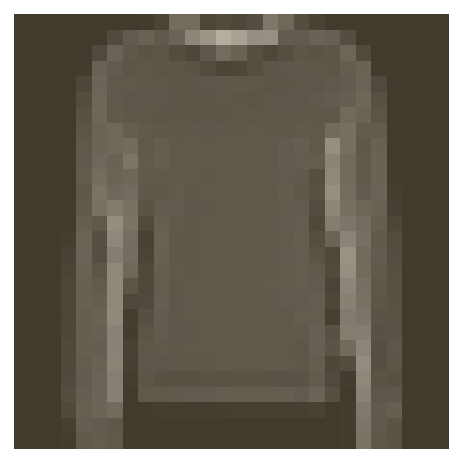

In [5]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

# Train a network

To make things more concise here, I moved the model architecture and training code from the last part to a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [6]:
# Create the network, define the criterion and optimizer
import fc_model
model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.700..  Test Loss: 0.978..  Test Accuracy: 0.586
Epoch: 1/2..  Training Loss: 1.045..  Test Loss: 0.758..  Test Accuracy: 0.717
Epoch: 1/2..  Training Loss: 0.867..  Test Loss: 0.711..  Test Accuracy: 0.728
Epoch: 1/2..  Training Loss: 0.755..  Test Loss: 0.639..  Test Accuracy: 0.753
Epoch: 1/2..  Training Loss: 0.748..  Test Loss: 0.656..  Test Accuracy: 0.753
Epoch: 1/2..  Training Loss: 0.736..  Test Loss: 0.622..  Test Accuracy: 0.764
Epoch: 1/2..  Training Loss: 0.725..  Test Loss: 0.609..  Test Accuracy: 0.768
Epoch: 1/2..  Training Loss: 0.685..  Test Loss: 0.567..  Test Accuracy: 0.782
Epoch: 1/2..  Training Loss: 0.635..  Test Loss: 0.552..  Test Accuracy: 0.787
Epoch: 1/2..  Training Loss: 0.655..  Test Loss: 0.565..  Test Accuracy: 0.796
Epoch: 1/2..  Training Loss: 0.630..  Test Loss: 0.542..  Test Accuracy: 0.797
Epoch: 1/2..  Training Loss: 0.597..  Test Loss: 0.519..  Test Accuracy: 0.810
Epoch: 1/2..  Training Loss: 0.605..  Test Loss: 0.5

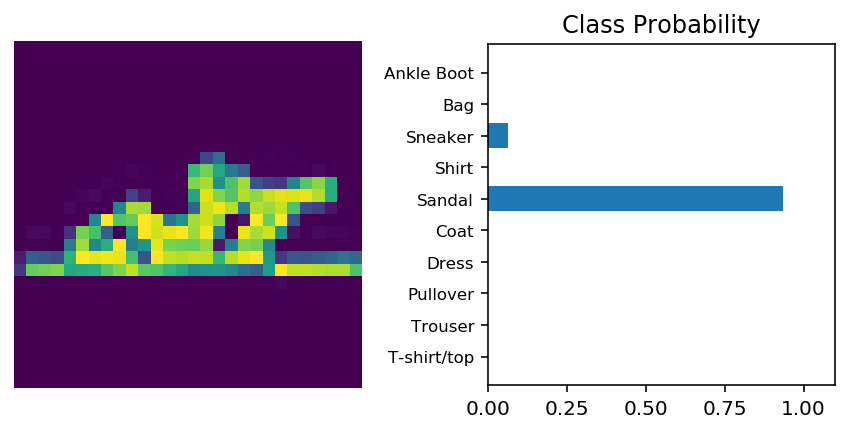

In [8]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [9]:
#inspect model hidden layers
print('model hidden layers ',model.hidden_layers)
print('out features ')
for X in model.hidden_layers:
    print(' ',X.out_features)
#

model hidden layers  ModuleList(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=256, bias=True)
  (2): Linear(in_features=256, out_features=128, bias=True)
)
out features 
  512
  256
  128


## Saving and loading networks

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

Then we can load the state dict with `torch.load`.

And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

In [10]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [11]:
#alternative implementation of previous cell
HL_LI =[]
for X in model.hidden_layers:
    HL_LI.append(X.out_features)
print(HL_LI)

checkpoint_new = {'input_size': 784,
                  'output_size': 10,
                  'hidden_layers': HL_LI,
                  'state_dict': model.state_dict()}
torch.save(checkpoint_new, 'checkpoint_new.pth')

[512, 256, 128]


Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints. 

In [12]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [14]:
model1 = load_checkpoint('checkpoint_new.pth')
print(model1)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


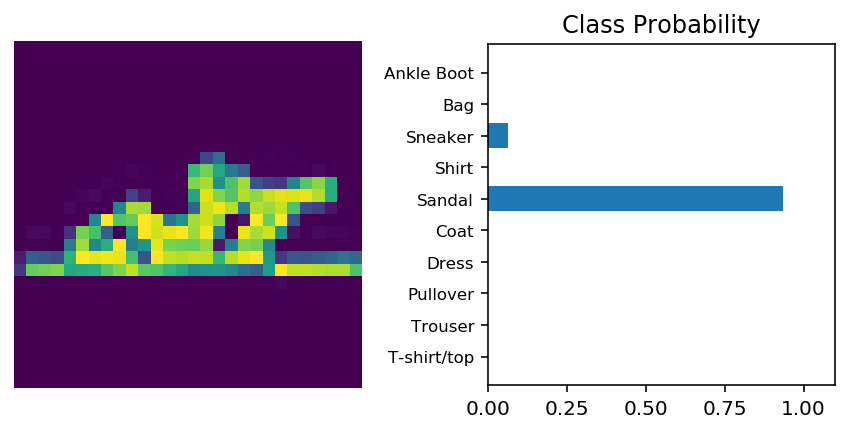

In [15]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model1.eval()

#dataiter = iter(testloader)
#images, labels = dataiter.next()
#img = images[0]
# Convert 2D image to 1D vector
#img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model1.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')